# analyze mac $n=30$

In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from utils import calculate_rate, calculate_mac_rate_pairs, create_model
import os
import json
from types import SimpleNamespace
import tensorflow as tf

from plotting import get_tex_fonts, set_size


n=30
L=50
snr_set = np.linspace(-1.5,3,4)

iterations_set = [1, 2, 5, 10, 50, 100]
iter_to_use=50

exp = 'mac_three_users_n30_fp'
data_dir = '/scratch/users/cmatson/nn-codes/data/'
experiment_dir = os.path.join(data_dir, f'experiment_{exp}')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from utils import calculate_rate, create_model
import os
import json
from types import SimpleNamespace
import tensorflow as tf



n=30
L=50
snr_set = np.linspace(-1.5,3,4)

iterations_set = [1, 2, 5, 10, 50, 100]
iter_to_use=50

exp = 'mac_three_users_n30_fp'
data_dir = '/scratch/users/cmatson/nn-codes/data/'
experiment_dir = os.path.join(data_dir, f'experiment_{exp}')

#### load single user results

In [4]:
experiment_set = []
mac_set=[]
test = 0
for snr1 in snr_set:
    k1, _, r1, c1 = calculate_rate(k=None, n=n, SNR=snr1)
    experiment_set.append((test, k1, snr1, snr1, 1)) # test, k, snr, snr_eff, h
    i1=test
    test+=1
    
    for snr2 in snr_set:
        N0 = 10**(-snr1/10)

        # calculate the scale factor and effective snr for U2 st we have same N0
        h2 = N0*10**(snr2/10)
        snr2_eff = 10*np.log10(h2/(1+N0))
        
        k2, _, r2, c2 = calculate_rate(k=None, n=n, SNR=snr2_eff)
        if k2==0:
            continue
        experiment_set.append((test, k2, snr2, snr2_eff, h2))
        i2=test
        test+=1

        for snr3 in snr_set:
            # calculate the scale factor and effective snr for U3 st we have same N0
            h3 = N0*10**(snr3/10)
            snr3_eff = 10*np.log10(h3/(1+h2+N0))
        
            k3, _, r3, c3 = calculate_rate(k=None, n=n, SNR=snr3_eff)
            if k3==0:
                continue
            experiment_set.append((test, k3, snr3, snr3_eff, h3))
            i3=test
            test+=1
            
            
            mac_set.append((i1, i2, i3))

#### load single user results

In [5]:
performance_ber = []
performance_gp = []
for test, (t, k, snr, snr_eff, h) in enumerate(experiment_set):
    if not os.path.exists(os.path.join(experiment_dir, f'test_{test}', 'val_history.npy')):
        print(f' {test} did not complete')
        didnot.append(test)
        continue
    hv = np.load(os.path.join(experiment_dir, f'test_{test}', 'val_history.npy'), allow_pickle=True).item()
    
        
    performance_ber.append(1-max(hv['binary_accuracy']))
    performance_gp.append((k/n)*max(hv['binary_accuracy']))


    
    if False:
        fig, ax = plt.subplots(1,2, tight_layout=True)
        ax[0].plot(hv['loss'], label='loss')
        ax[0].set_xlim([0,101])
        ax[0].set_title('loss')

        ax[1].plot(1-np.array(hv['binary_accuracy']), 'r-', label='acc')
        ax[1].set_xlim([0,101])
#         ax[1].set_yscale('log')
        ax[1].set_ylim([0,.15])
        ax[1].set_title('acc')

        fig.suptitle(f'{test}: {k}/{n} @ snr {snr_eff:.1f}')
performance_ber = np.array(performance_ber)
performance_gp = np.array(performance_gp)

2022-04-14 09:04:37.382441: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-14 09:04:37.384022: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-04-14 09:04:37.434679: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:06:00.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-04-14 09:04:37.434741: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-04-14 09:04:37.440968: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-04-14 09:04:37.441033: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11

#### load the sic data

In [6]:
sic3_data = np.load(os.path.join(experiment_dir, f'sic3_n{n}_data.npy'))
sic2_data = np.load(os.path.join(experiment_dir, f'sic2_n{n}_data.npy'))

# lets do some plotting

### iteration performance

In [7]:
def get_mac_idx(snr1, snr2, snr3=None):
    idx1 = []
    for t, k, snr, snr_eff, h in experiment_set:
        if snr==snr1:
            idx1.append(t)

    idx2=[]
    for t, k, snr, snr_eff, h in experiment_set:
        if snr==snr2:
            idx2.append(t)
    
    if snr3 is not None:
        idx3=[]
        for t, k, snr, snr_eff, h in experiment_set:
            if snr==snr3:
                idx3.append(t)

    macidx=[]
    for test,(i1,i2,i3) in enumerate(mac_set):
        if i1 in idx1 and i2 in idx2 and (snr3 is None or i3 in idx3):
            macidx.append(test)

    return macidx[0]

In [97]:
def plot_iteration_results(mac_test, i1, i2, i3, fig, ax):
    colors=['r','b','g']
    colors=['#1f77b4', '#ff7f0e', '#2ca02c'] # mpl defaults

    snr1=experiment_set[i1][2]
    snr2=experiment_set[i2][2]
    snr3=experiment_set[i3][2]
    
    snr2_eff=experiment_set[i2][3]
    snr3_eff=experiment_set[i3][3]
    
    for i in range(3):
        # iteration, ber, gp, mse
        ax.plot(iterations_set, sic3_data[mac_test][:,1,i], 'o-', color=colors[i], label=f'u{i+1} 3-MAC')
    for j in range(2):
        ax.plot(iterations_set, sic2_data[mac_test][:,1,j], 'v--', color=colors[j], label=f'u{j+1} 2-MAC')
    
    ax.set_xlabel('Iteration')
    ax.set_ylabel('BER')
    ax.set_yscale('log')
#     ax.set_ylim([, 1.1*np.max(sic3_data[:,:,1])])
    ax.legend(ncol=2)
#     ax.set_title(f'{mac_test}: {snr1:.3f}, {snr2_eff:.3f}, {snr3_eff:.3f}')

    return ax

/tmp/ipykernel_28984/1574533005.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1,figsize=(set_size(width='conference', fraction=0.5)), tight_layout=True)


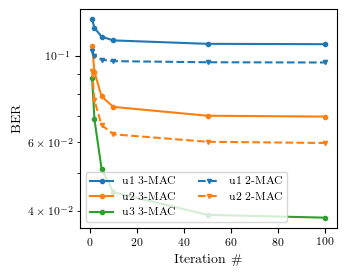

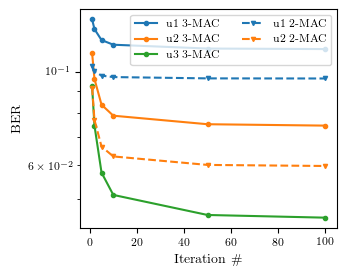

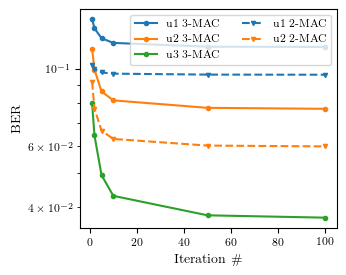

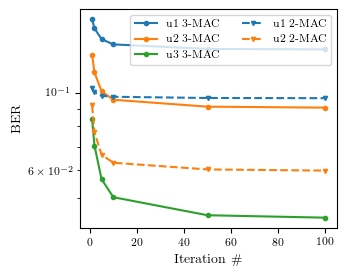

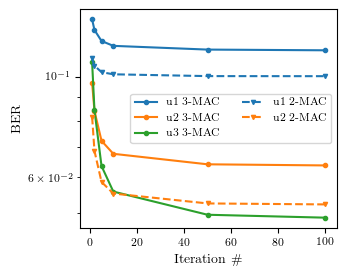

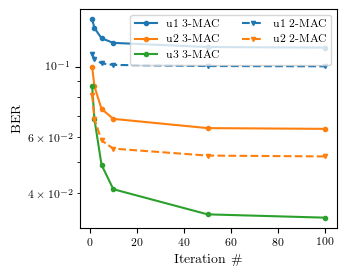

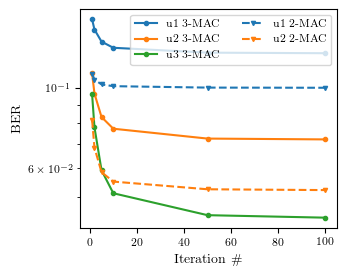

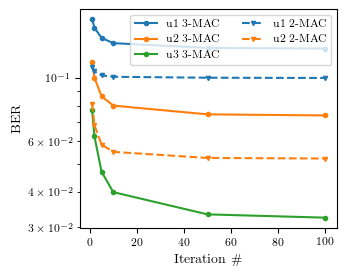

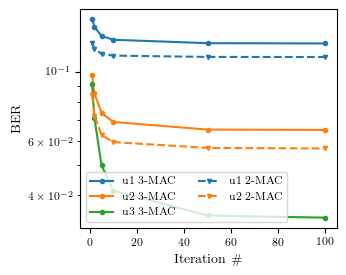

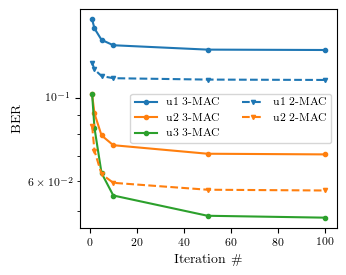

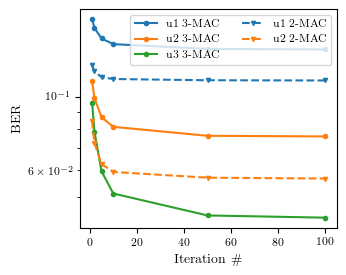

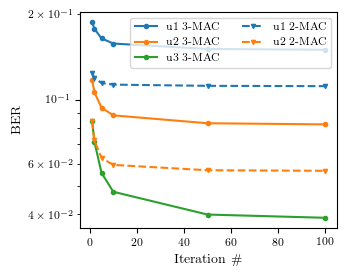

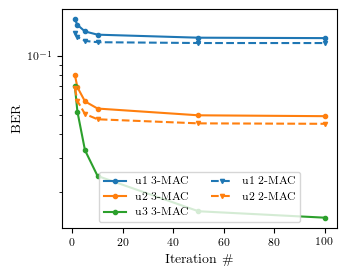

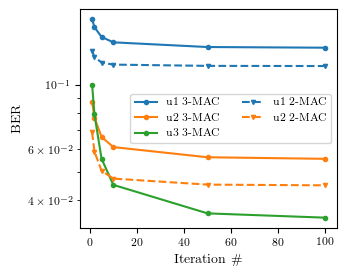

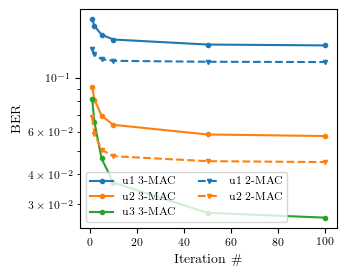

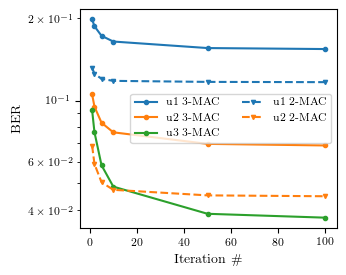

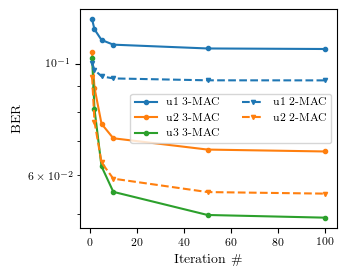

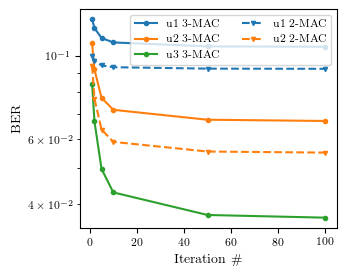

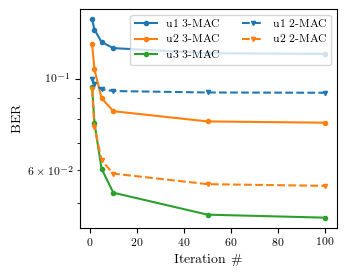

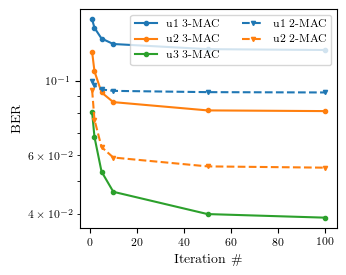

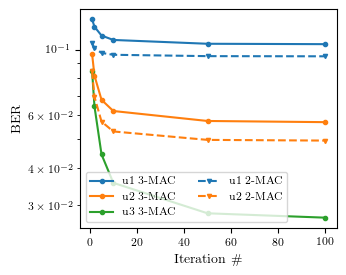

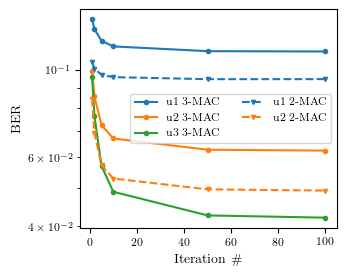

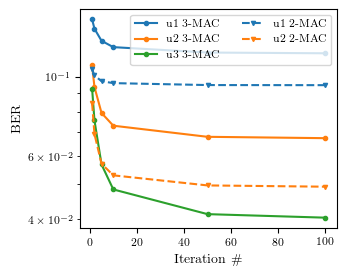

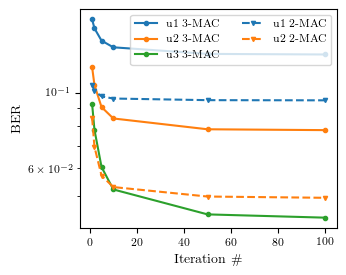

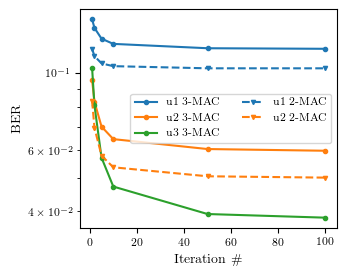

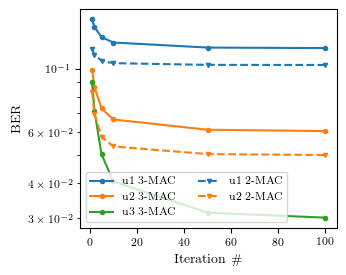

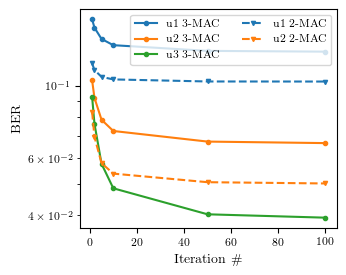

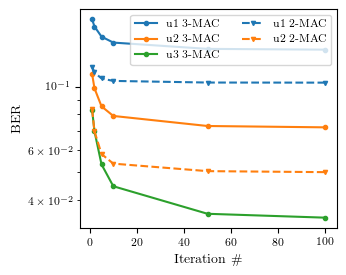

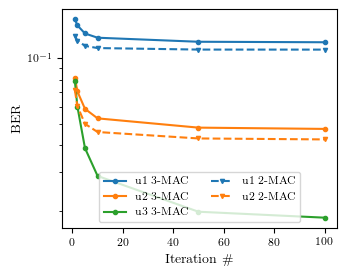

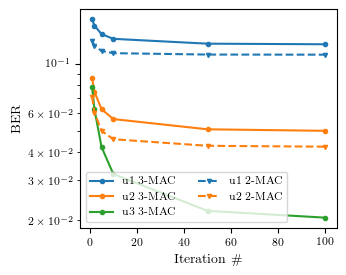

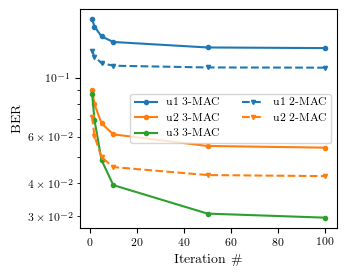

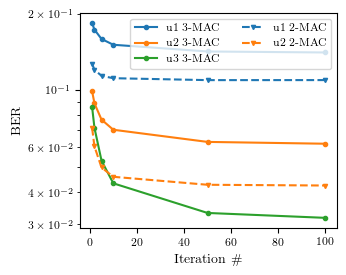

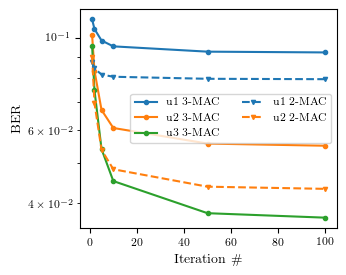

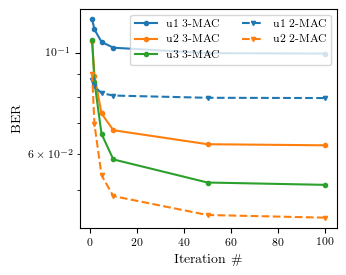

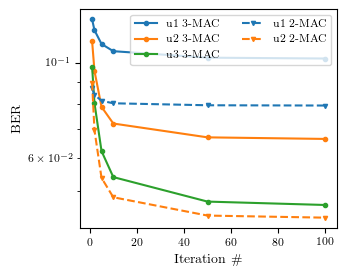

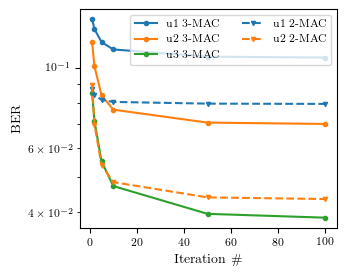

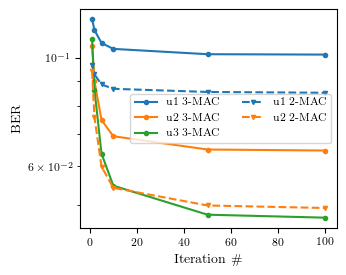

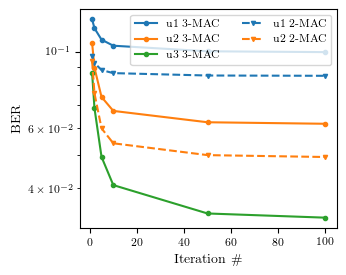

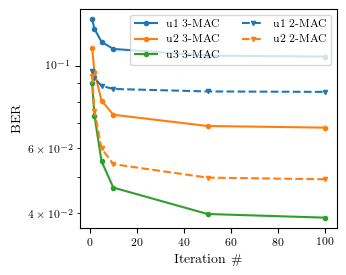

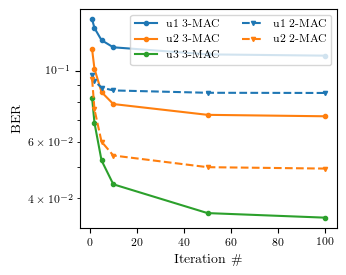

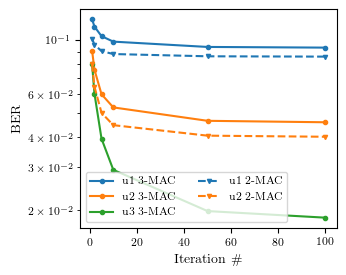

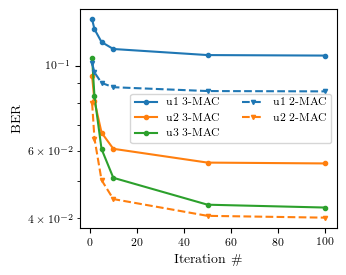

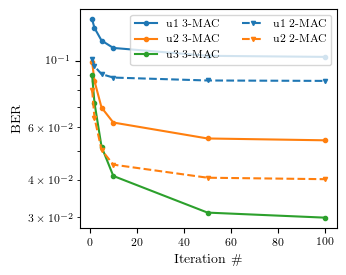

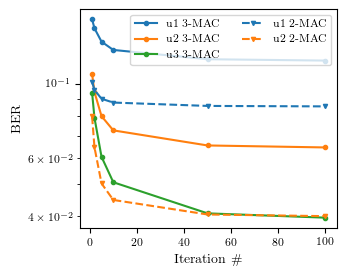

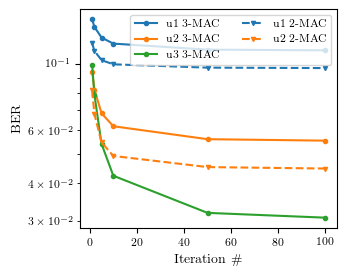

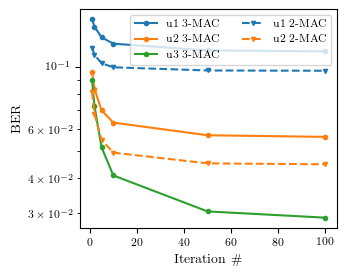

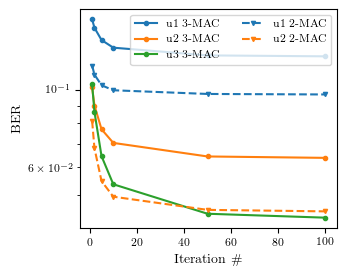

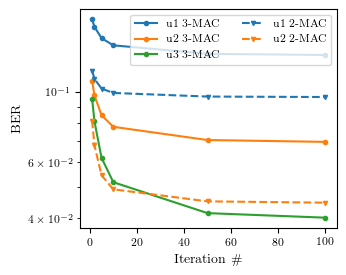

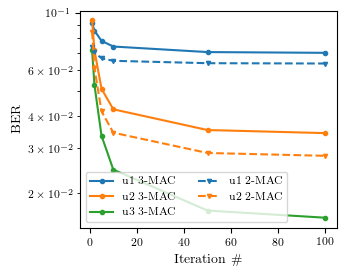

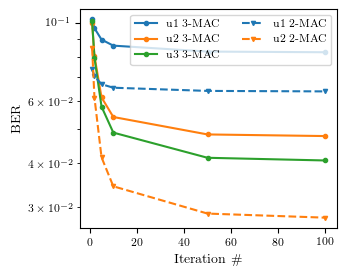

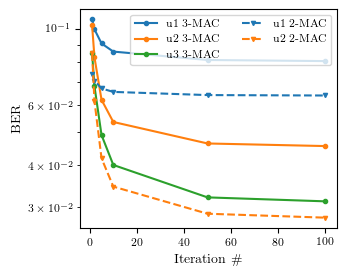

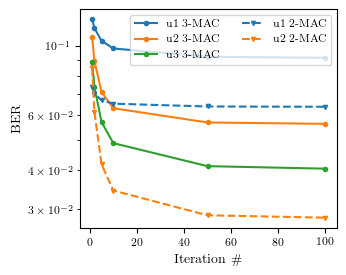

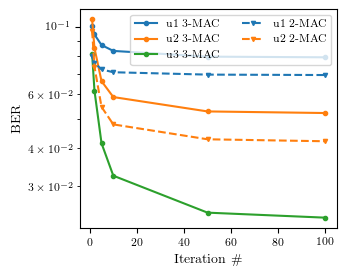

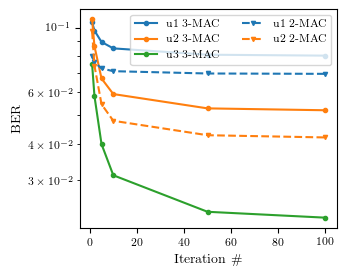

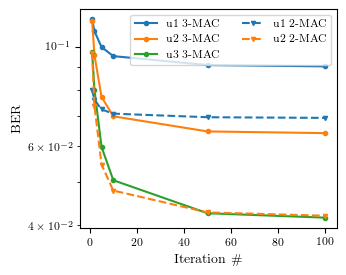

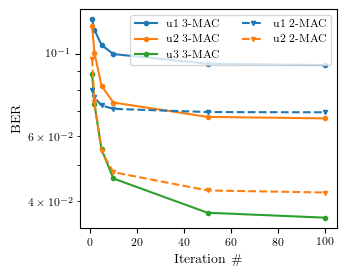

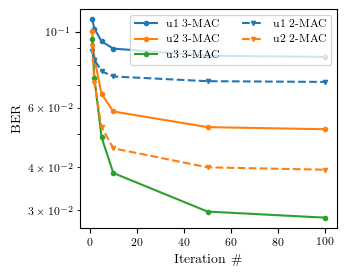

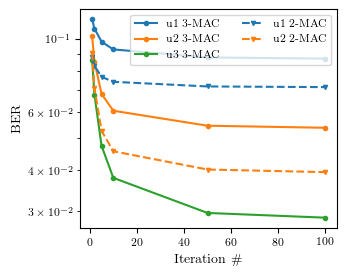

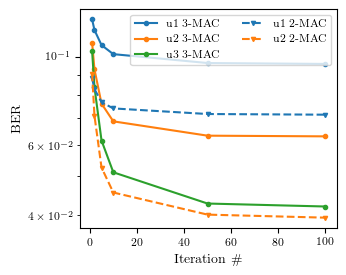

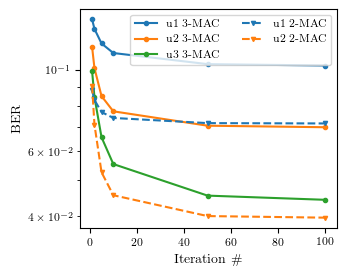

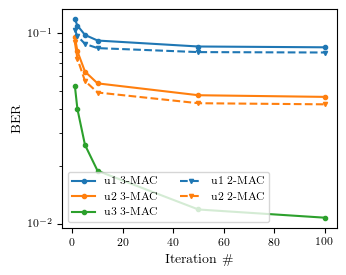

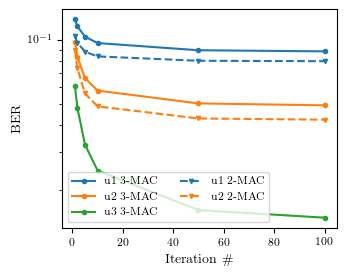

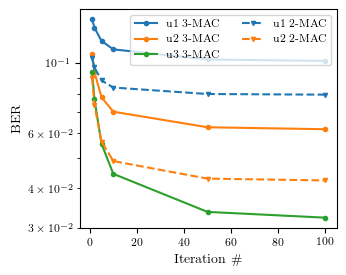

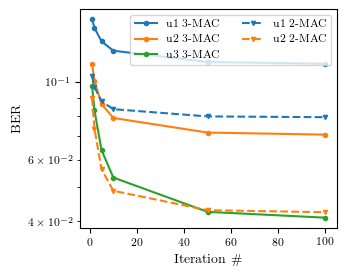

In [95]:
import matplotlib.pyplot as plt
for mac_test, (i1, i2, i3) in enumerate(mac_set):
#     if mac_test not in np.arange(0,len(mac_set),4):
#         continue
    if PUBLISH:
        fig, ax = plt.subplots(1,1,figsize=(set_size(width='conference', fraction=0.5)), tight_layout=True)
    else:
        fig, ax = plt.subplots(1, 1,tight_layout=True)
    
    ax = plot_iteration_results(mac_test, i1, i2, i3, fig, ax)
    
    if PUBLISH:
        fig.savefig(f'./figures/iterations/test_{mac_test}_{snr1}_{snr2}_{snr3}.pdf')
        

mac3 improvement:  [0.24579324 0.44778386 0.65431404]
mac2 improvement:  [0.15304708 0.49334437]


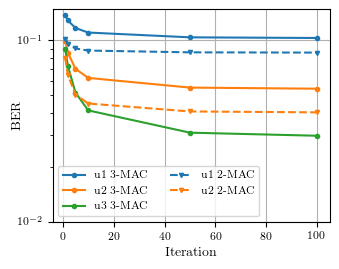

In [130]:
mac_test = get_mac_idx(snr1=1.5, snr2=1.5, snr3=1.5)
i1, i2, i3 = mac_set[mac_test]

plt.rcParams.update(get_tex_fonts())
fig, ax = plt.subplots(1,1,figsize=set_size(width='conference', fraction=0.49), tight_layout=True)

# plt.rcParams.update(plt.rcParamsDefault)
# fig, ax = plt.subplots(1,1,figsize=(8,4),tight_layout=True)

ax = plot_iteration_results(mac_test, i1, i2, i3, fig, ax)
ax.grid('on')
ax.legend(ncol=2,)
ax.set_ylabel(ax.get_ylabel(),labelpad=-3)
ax.set_ylim([1e-2, ax.get_ylim()[-1]])
fig.savefig('./figures/iterations_result.pdf')
print('mac3 improvement: ', (sic3_data[mac_test, 0, 1]-sic3_data[mac_test, -2, 1])/sic3_data[mac_test, 0, 1])
print('mac2 improvement: ', (sic2_data[mac_test, 0, 1]-sic2_data[mac_test, -2, 1])/sic2_data[mac_test, 0, 1])

In [9]:
print('mac3 average ber improvment after 50 iterations (each user): {:.1%}, {:.1%}, {:.1%}'.format(*np.mean((sic3_data[:, 0, 1] - sic3_data[:, -2, 1])/(sic3_data[:, 0, 1]), axis=0)))

mac3 average ber improvment after 50 iterations (each user): 20.3%, 39.6%, 60.1%


In [10]:
print('mac2 average ber improvment after 50 iterations (each user): ', np.mean((sic2_data[:, 0, 1] - sic2_data[:, -2, 1])/(sic2_data[:, 0, 1]), axis=0))

mac2 average ber improvment after 50 iterations (each user):  [0.1253532  0.45055563]


Text(0.5, 1.0, 'mac average ber improvement')

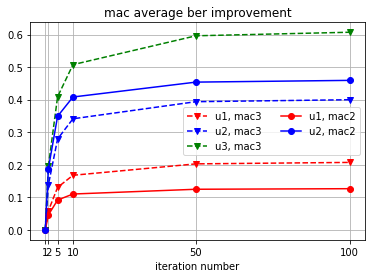

In [12]:
color=['r','b','g']
for i in range(3):
    plt.plot(iterations_set, 
             (np.mean(sic3_data[:, 0, 1,i], axis=0) - np.mean(sic3_data[:, :, 1,i], axis=0))/np.mean(sic3_data[:, 0, 1,i], axis=0),
             'v--', color=color[i], label=f'u{i+1}, mac3')

for i in range(2):
    plt.plot(iterations_set, 
             
             (np.mean(sic2_data[:, 0, 1,i], axis=0) - np.mean(sic2_data[:, :, 1,i], axis=0))/np.mean(sic2_data[:, 0, 1,i], axis=0),
             'o-', color=color[i], label=f'u{i+1}, mac2')

    
plt.legend(ncol=2)
plt.xlabel('iteration number')
plt.xticks(iterations_set)
plt.grid('on')
plt.title('mac average ber improvement')

Text(0.5, 1.0, '% improvement after 50 iterations each snr test')

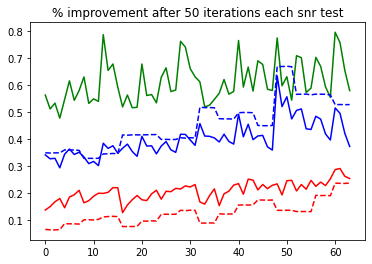

In [14]:
color=['r','b','g']
for i in range(3):
    plt.plot((sic3_data[:, 0, 1,i] - sic3_data[:, -1, 1,i])/(sic3_data[:, 0, 1,i]), '-', color=color[i])
for i in range(2):
    plt.plot((sic2_data[:, 0, 1,i] - sic2_data[:, -1, 1,i])/(sic2_data[:, 0, 1,i]), '--', color=color[i])
    
plt.title('% improvement after 50 iterations each snr test')

### 3 user gp

In [9]:
# iter_to_use = 50
# PUBLISH=False
# for mac_test, (i1, i2, i3) in enumerate(mac_set):
    
# #     if mac_test >0:
# #         continue
        
#     #test, k, snr, snr_eff, h
#     snr1=experiment_set[i1][2]
#     snr2=experiment_set[i2][2]
#     snr3=experiment_set[i3][2]
#     snr2_eff=experiment_set[i2][3]
#     snr3_eff=experiment_set[i3][3]

#     mac_cap = [calculate_rate(k=None, n=n, SNR=snr)[-1] for snr in [snr1, snr2_eff, snr3_eff]]
#     mac_rate = [calculate_rate(k=None, n=n, SNR=snr)[-2] for snr in [snr1, snr2_eff, snr3_eff]]


#     mac_gp = np.squeeze(sic3_data[mac_test,np.array(iterations_set)==iter_to_use,2,:])
    
#     if PUBLISH:
#         fig, ax = plt.subplots(1,1,figsize=(set_size(width='conference', fraction=0.5)))
#     else:
#         fig, ax = plt.subplots(1, 1,tight_layout=True)
    
#     ax.bar(range(3), mac_cap, label=f'capacity')
#     ax.bar(range(3), mac_rate, label=f'code rate $\\frac{{k}}{{n}}$')
#     ax.bar(range(3), mac_gp, label=f'gp {iter_to_use} iter.')
    
#     ax.set_xticks(range(3))
#     ax.set_xticklabels([f'{user}: {snr:.3f} ({snr_eff:.3f})' for user, snr, snr_eff in zip(np.arange(1,4), 
#                                                           (snr1, snr2, snr3),
#                                                           (snr1, snr2_eff, snr3_eff))])
#     ax.set_xlabel('User: SNR ($\\mathrm{SNR}_{eff}$)')
#     ax.set_ylim([0, 1.2*np.max(sic3_data[:,np.array(iterations_set)==iter_to_use,2,:])])
#     ax.set_ylabel('Rate')
#     ax.legend()
    
#     if PUBLISH:
#         fig.savefig(f'./figures/3user_rates/test_{mac_test}_{snr1}_{snr2}_{snr3}.pdf')




## pentagons

In [115]:
from matplotlib.cm import Blues as cm
color_idx = np.linspace(0.3,0.9,4)

def plot_sic_results(mac_test, i1, i2, i3, fig, ax, do_text=True, user3=False):
    #test, k, snr, snr_eff, h
    snr1=experiment_set[i1][2]
    snr2=experiment_set[i2][2]
    snr2_eff=experiment_set[i2][3]
    snr3=experiment_set[i3][2]

    # get the complement u1 u2 scenario
    flip_mac_test = get_mac_idx(snr1=snr2, snr2=snr1, snr3=snr3)
    snr1_eff=experiment_set[mac_set[flip_mac_test][1]][3]
    
    (mac2_gp1, mac2_gp2) = np.squeeze(sic2_data[mac_test,np.array(iterations_set)==iter_to_use,2,:])
    (mac2_gp1_flip, mac2_gp2_flip) = np.squeeze(sic2_data[flip_mac_test,np.array(iterations_set)==iter_to_use,2,:])
    
    plot_pentagon(n, snr1, snr2, fig, ax, do_text=do_text)
    
    # single user results
    gp1 = performance_gp[i1]
    gp2 = performance_gp[mac_set[flip_mac_test][0]]
    ax.plot([gp1, 0, 0.5*gp1], [0, gp2, 0.5*gp2], 'gs', label='1-user GP')
    
    
    # decode user 2 first
    ax.plot(mac2_gp1, mac2_gp2, 'ro', label=f'2-user GP')

    # flip - decode user 1 first
    ax.plot(mac2_gp2_flip, mac2_gp1_flip, 'ro')
    
    # time-sharing
    mac2_gp1_ts = mac2_gp2_flip + 0.5*(mac2_gp1-mac2_gp2_flip)
    mac2_gp2_ts = mac2_gp1_flip+0.5*(mac2_gp2-mac2_gp1_flip)
    ax.plot(mac2_gp1_ts, mac2_gp2_ts, 'ro')
    
    
    
    # with user 3
    if user3:
        for i in range(4):
            snr3=experiment_set[i3+i][2]
            print(snr3)
            flip_mac_test = get_mac_idx(snr1=snr2, snr2=snr1, snr3=snr3)
    
            (mac3_gp1, mac3_gp2, _) = np.squeeze(sic3_data[mac_test+i,np.array(iterations_set)==iter_to_use,2,:])
            (mac3_gp1_flip, mac3_gp2_flip, _) = np.squeeze(sic3_data[flip_mac_test,np.array(iterations_set)==iter_to_use,2,:])

            sum_gp3_d = mac3_gp1+mac3_gp2
            sum_gp3_b = mac3_gp2_flip+mac3_gp1_flip
            sum_gp2_d = mac2_gp1+mac2_gp2
            sum_gp2_b = mac2_gp2_flip+mac2_gp1_flip

            dropoff_d = (sum_gp2_d-sum_gp3_d)/sum_gp2_d
            dropoff_b = (sum_gp2_b-sum_gp3_b)/sum_gp2_b

            print(f'two user b: {sum_gp2_b:.4f}, three user b: {sum_gp3_b:.4f}, reduction: {dropoff_b:.4f}')
            print(f'two user d: {sum_gp2_d:.4f}, three user d: {sum_gp3_d:.4f}, reduction: {dropoff_d:.4f}')


#             ax.plot(mac3_gp1, mac3_gp2, 'v', color=cm(color_idx[i]), label=f'2-user GP w/u3 ({snr3:.1f})')
            ax.plot(mac3_gp1, mac3_gp2, 'v', color=cm(color_idx[i]), label=f'2-user GP w/u3' if i==2 else '')
            ax.plot(mac3_gp2_flip, mac3_gp1_flip, 'v', color=cm(color_idx[i]))
            print('')
    
    
    # style
    ax.axis('square')
    ax.set_xlim([0, 1])
#     ax.set_xlabel(f'$R_1 \\mathrm{{SNR}}_1={{{snr1}}}(\mathrm{{SNR}}_{{1,eff}}={{{snr1_eff:.2f}}})$')
    ax.set_xlabel(f'$R_1 \;\; \\mathrm{{SNR}}_1={{{snr1}}}$')


    ax.set_ylim([0, 1])
#     ax.set_ylabel(f'$R_2  \\mathrm{{SNR}}_2={{{snr2}}}(\mathrm{{SNR}}_{{2,eff}}={{{snr2_eff:.2f}}})$')
    ax.set_ylabel(f'$R_2 \;\; \\mathrm{{SNR}}_2={{{snr2}}}$')


    # compute which corner is best
    _, _, r1, c1, _, r2_mac, c2_mac = calculate_mac_rate_pairs(n, snr1, snr2) # u1 at full rate (point D)
    _, _, r2, c2, _, r1_mac, c1_mac = calculate_mac_rate_pairs(n, snr2, snr1) # u2 at full rate (point B)
    
    d_sum_ratio =  (mac2_gp1+mac2_gp2) / (c1+c2_mac)
    b_sum_ratio =  (mac2_gp2_flip+mac2_gp1_flip)/ (c1_mac+c2)
    
    print(f'{mac_test}: (snr1, snr2)=({snr1},{snr2}): sum_b={b_sum_ratio:.4f}, sum_d={d_sum_ratio:.4f}, {"=" if snr1==snr2 else ("<" if snr1 < snr2 else ">")}, {"C" if b_sum_ratio==d_sum_ratio else ("B" if b_sum_ratio>d_sum_ratio else "D")}')
    
    d_norm = np.linalg.norm([mac2_gp1, mac2_gp2])
    b_norm = np.linalg.norm([mac2_gp2_flip, mac2_gp1_flip])
#     ax.set_title(f'D:{d_norm:.3f}, B:{b_norm:.3f}, {"C" if b_norm == d_norm else ("B" if b_norm >= d_norm else "D")}')

    
    return ax, (d_sum_ratio-b_sum_ratio)

-1.5
two user b: 0.5506, three user b: 0.5441, reduction: 0.0117
two user d: 0.5506, three user d: 0.5441, reduction: 0.0117

0.0
two user b: 0.5506, three user b: 0.5408, reduction: 0.0177
two user d: 0.5506, three user d: 0.5408, reduction: 0.0177

1.5
two user b: 0.5506, three user b: 0.5394, reduction: 0.0204
two user d: 0.5506, three user d: 0.5394, reduction: 0.0204

3.0
two user b: 0.5506, three user b: 0.5298, reduction: 0.0377
two user d: 0.5506, three user d: 0.5298, reduction: 0.0377



NameError: name 'calculate_mac_rate_pairs' is not defined

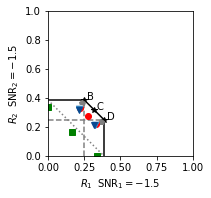

In [16]:

from utils import plot_pentagon

max_single_user_rate = calculate_rate(k=None, n=n, SNR=snr_set[-1])[-1]

PUBLISH=True
op = np.zeros((4,4))
for mac_test, (i1, i2, i3) in enumerate(mac_set):
    if mac_test not in np.arange(0,64,4): continue
    
    if PUBLISH:
        fig, ax = plt.subplots(1,1,figsize=(set_size(width='conference', fraction=0.5)), tight_layout=True)
    else:
        fig, ax = plt.subplots(1, 1,tight_layout=True)
        
    ax, point = plot_sic_results(mac_test, i1,i2,i3, fig, ax, user3=True)
    op[snr_set==experiment_set[i1][2], snr_set==experiment_set[i2][2]]=point
    ax.legend()
#     if PUBLISH:
#         fig.savefig(f'./figures/2vs3user_pentagon/test_{mac_test}_{snr1}_{snr2}_{snr3}.pdf')



(0.0, 1.0)

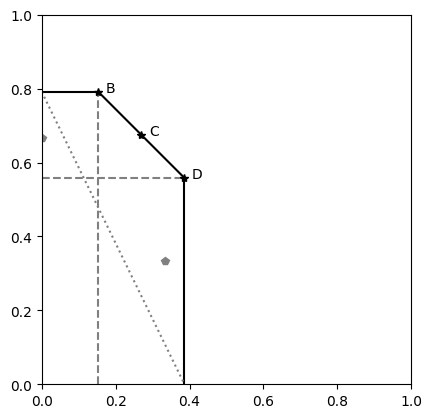

In [24]:
plt.rcParams.update(plt.rcParamsDefault)
fig, ax = plt.subplots()
plot_pentagon(n=3, snr1=-1.5, snr2=3, fig=fig, ax=ax)
ax.axis('square')
ax.set_xlim([0,1])
ax.set_ylim([0,1])



-1.5
two user b: 0.8667, three user b: 0.8598, reduction: 0.0079
two user d: 0.8667, three user d: 0.8598, reduction: 0.0079

0.0
two user b: 0.8667, three user b: 0.8490, reduction: 0.0204
two user d: 0.8667, three user d: 0.8490, reduction: 0.0204

1.5
two user b: 0.8667, three user b: 0.8509, reduction: 0.0182
two user d: 0.8667, three user d: 0.8509, reduction: 0.0182

3.0
two user b: 0.8667, three user b: 0.8385, reduction: 0.0325
two user d: 0.8667, three user d: 0.8385, reduction: 0.0325

40: (snr1, snr2)=(1.5,1.5): sum_b=0.8956, sum_d=0.8956, =, C
12: (snr1, snr2)=(-1.5,3.0): sum_b=0.8970, sum_d=0.8821, <, B
-1.5
two user b: 0.8667, three user b: 0.8598, reduction: 0.0079
two user d: 0.8667, three user d: 0.8598, reduction: 0.0079

0.0
two user b: 0.8667, three user b: 0.8490, reduction: 0.0204
two user d: 0.8667, three user d: 0.8490, reduction: 0.0204

1.5
two user b: 0.8667, three user b: 0.8509, reduction: 0.0182
two user d: 0.8667, three user d: 0.8509, reduction: 0.0182



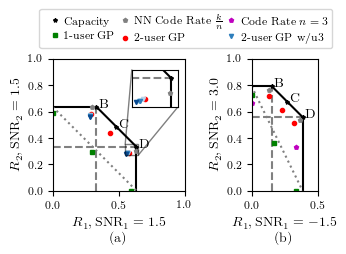

In [124]:
from plotting import set_size, get_tex_fonts
from utils import plot_pentagon

# mac_test_g = get_mac_idx(snr1=1.5, snr2=0) # snr1>snr2
mac_test_asym = get_mac_idx(snr1=-1.5, snr2=3.0) # snr1<<snr2
mac_test_eq = get_mac_idx(snr1=1.5, snr2=1.5, snr3=-1.5) # snr1=snr2

i1_asym, i2_asym, i3_asym = mac_set[mac_test_asym]
i1_eq, i2_eq, i3_eq = mac_set[mac_test_eq]


plt.rcParams.update(get_tex_fonts())
fig, ax = plt.subplots(1,2,figsize=set_size(width='conference', fraction=.6, subplots=(1,2)), 
                       gridspec_kw={'wspace':0.}, 
                       dpi=100)
# fig, ax = plt.subplots(1,2,figsize=(8,4))
# plt.rcParams.update(plt.rcParamsDefault)

ax_eq,_ = plot_sic_results(mac_test_eq, i1_eq, i2_eq, i3_eq, fig, ax[0], user3=True)
ax_asym,_ = plot_sic_results(mac_test_asym, i1_asym, i2_asym, i3_asym, fig, ax[1])

#plot n=3 rates on aysm axis
_, _, r1, c1, _, r2_mac, c2_mac = calculate_mac_rate_pairs(n=3, snr1=-1.5, snr2=3) # u1 at full rate
_, _, r2, c2, _, r1_mac, c1_mac = calculate_mac_rate_pairs(n=3, snr2=-1.5, snr1=3) # u2 at full rate
n3=ax_asym.plot([r1, r1_mac], [r2_mac, r2], 'mp', label='Code Rate $n=3$')

# plot inset zoom on equal axis
axins = ax_eq.inset_axes([0.6, 0.6, 0.35, 0.35])
plot_sic_results(mac_test_eq, i1_eq, i2_eq, i3_eq, fig, axins, do_text=False, user3=True)



axins.axis('square')
axins.set_xlim([0.55,0.65])
axins.set_ylim([0.27, 0.35])
axins.set_yticks([])
axins.set_xticks([])
axins.set_ylabel('')
axins.set_xlabel('')
ax_eq.indicate_inset_zoom(axins, edgecolor='k')

ax_eq.legend()
ax_eq.legend(handles=list(np.insert(ax_eq.get_legend_handles_labels()[0], 2, n3[0])[[0,3,1,4,2,5]]), 
             labels=list(np.insert(ax_eq.get_legend_handles_labels()[1], 2, n3[0].get_label())[[0,3,1,4,2,5]]),
#     bbox_to_anchor=(-1.2, 1.08, 3.4, .105), 
            bbox_to_anchor=(-0.1, 1.08, 2.22, .105), 
            loc='lower left',
            ncol=3, mode='expand', borderaxespad=0., 
            handletextpad=-0.17, columnspacing=-0.0,
          )



ax[0].set_xlabel('$R_1, \\mathrm{SNR}_1=1.5$\n(a)')
ax[0].set_ylabel('$R_2, \\mathrm{SNR}_2=1.5$')
ax[1].set_xlim([0,.5])
ax[1].set_xlabel('$R_1, \\mathrm{SNR}_1=-1.5$\n(b)')
ax[1].set_ylabel('$R_2, \\mathrm{SNR}_2=3.0$')

# axcb = ax_eq.inset_axes([0.6,0.57,0.4,0.1], transform=ax_eq.transAxes)
# axcb.axis('off')
# cmap = mpl.cm.Blues
# cmap = mpl.colors.LinearSegmentedColormap.from_list('Upper Half', mpl.cm.Blues(np.linspace(0.3,0.9,4)))
# norm = mpl.colors.BoundaryNorm(np.linspace(-2.25,3.75,5), cmap.N)
# cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), 
#                     ax=axcb, 
#                     shrink=.7,
#                   orientation='horizontal',
#                   ticklocation='bottom'
#                 )

# cb.set_ticks(snr_set[0:4:3])
# cb.set_label('$\\mathrm{SNR}_3$', labelpad=-20)


# fig.savefig('./figures/sic_results_pentagon.pdf',bbox_inches='tight',dpi='figure')
fig.savefig('./figures/sic_results_pentagon_short.pdf',bbox_inches='tight',dpi='figure')


In [87]:
n=30
_, _, r1, c1, _, r2_mac, c2_mac = calculate_mac_rate_pairs(n=n, snr1=-1.5, snr2=3) # u1 at full rate
_, _, r2, c2, _, r1_mac, c1_mac = calculate_mac_rate_pairs(n=n, snr2=-1.5, snr1=3) # u2 at full rate
print('{}: b r1+r2: {:.3f} + {:.3f} = {:.3f}'.format(n, *(r1_mac, r2), r1_mac+r2))
print('{}: d r1+r2: {:.3f} + {:.3f} = {:.3f}'.format(n, *(r1, r2_mac), r2_mac+r1))
from utils import calculate_interference_ch
print(calculate_interference_ch(snr1=-1.5, snr2=3))
print(calculate_interference_ch(snr2=-1.5, snr1=3))



30: b r1+r2: 0.133 + 0.767 = 0.900
30: d r1+r2: 0.367 + 0.533 = 0.900
(2.8183829312644537, 0.6752591931241358)
(0.3548133892335754, -6.264348624364854)


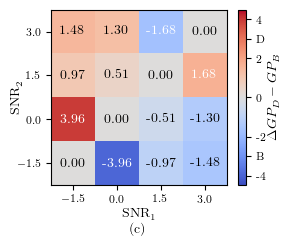

In [648]:
# import matplotlib as mpl
plt.rcParams.update(get_tex_fonts())
fig, ax = plt.subplots(1,1,figsize=set_size(width='conference', fraction=0.4), dpi=100)
im = ax.imshow(op, cmap=mpl.cm.get_cmap('coolwarm'), norm=mpl.colors.Normalize(vmin=-0.045, vmax=0.045),
           extent=[-2.25, 3.75, 3.75, -2.25]
          )

for i, snr1 in enumerate(snr_set):
    for j, snr2 in enumerate(snr_set):
        plt.text(snr2,snr1,f'{op[i,j]:.2%}',ha='center',va='center', color='k' if abs(op[i,j])<0.015 else 'w')
        pass

ax.invert_yaxis()
ax.set_xlabel('$\\mathrm{SNR}_1$\n(c)', labelpad=2)
ax.set_ylabel('$\\mathrm{SNR}_2$',labelpad=-4)
ax.set_xticks(snr_set)
ax.set_yticks(snr_set)
cb = fig.colorbar(im)
cb.set_ticks([-.04, -.03, -.02, 0, 0.02, 0.03, 0.04])
cb.set_ticklabels(['-4%', 'B', '-2%', '0', '2%', 'D', '4%'])
cb.set_label('$\Delta GP_D - GP_B$', labelpad=1)

fig.savefig('./figures/delta_gp2.pdf', bbox_inches='tight', dpi='figure')


-1.5
two user b: 0.8667, three user b: 0.8598, reduction: 0.0079
two user d: 0.8667, three user d: 0.8598, reduction: 0.0079

0.0
two user b: 0.8667, three user b: 0.8490, reduction: 0.0204
two user d: 0.8667, three user d: 0.8490, reduction: 0.0204

1.5
two user b: 0.8667, three user b: 0.8509, reduction: 0.0182
two user d: 0.8667, three user d: 0.8509, reduction: 0.0182

3.0
two user b: 0.8667, three user b: 0.8385, reduction: 0.0325
two user d: 0.8667, three user d: 0.8385, reduction: 0.0325

40: (snr1, snr2)=(1.5,1.5): sum_b=0.8956, sum_d=0.8956, =, C
12: (snr1, snr2)=(-1.5,3.0): sum_b=0.8970, sum_d=0.8821, <, B
-1.5
two user b: 0.8667, three user b: 0.8598, reduction: 0.0079
two user d: 0.8667, three user d: 0.8598, reduction: 0.0079

0.0
two user b: 0.8667, three user b: 0.8490, reduction: 0.0204
two user d: 0.8667, three user d: 0.8490, reduction: 0.0204

1.5
two user b: 0.8667, three user b: 0.8509, reduction: 0.0182
two user d: 0.8667, three user d: 0.8509, reduction: 0.0182



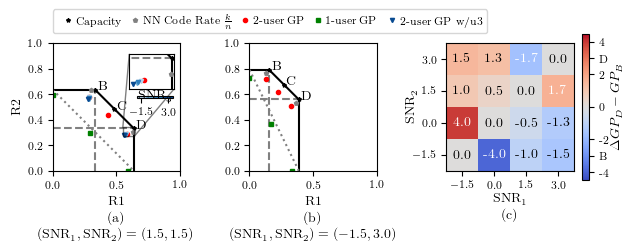

In [614]:
from plotting import set_size, get_tex_fonts
from utils import plot_pentagon

# mac_test_g = get_mac_idx(snr1=1.5, snr2=0) # snr1>snr2
mac_test_asym = get_mac_idx(snr1=-1.5, snr2=3.0) # snr1<<snr2
mac_test_eq = get_mac_idx(snr1=1.5, snr2=1.5, snr3=-1.5) # snr1=snr2

i1_asym, i2_asym, i3_asym = mac_set[mac_test_asym]
i1_eq, i2_eq, i3_eq = mac_set[mac_test_eq]


plt.rcParams.update(get_tex_fonts())
fig, ax = plt.subplots(1,3,figsize=set_size(width='conference', fraction=1, subplots=(1,3)), 
                       gridspec_kw={'width_ratios':[4,4,5], 'wspace':0.5}, 
                       dpi=100)
# fig, ax = plt.subplots(1,2,figsize=(8,4))
# plt.rcParams.update(plt.rcParamsDefault)

ax_eq,_ = plot_sic_results(mac_test_eq, i1_eq, i2_eq, i3_eq, fig, ax[0], user3=True)
plot_sic_results(mac_test_asym, i1_asym, i2_asym, i3_asym, fig, ax[1])

axins = ax_eq.inset_axes([0.6, 0.6, 0.35, 0.35])
plot_sic_results(mac_test_eq, i1_eq, i2_eq, i3_eq, fig, axins, do_text=False, user3=True)
axins.axis('square')
axins.set_xlim([0.55,0.64])
axins.set_ylim([0.27, 0.34])
axins.set_yticks([])
axins.set_xticks([])
axins.set_ylabel('')
axins.set_xlabel('')
ax_eq.indicate_inset_zoom(axins, edgecolor='k')

ax_eq.legend(
#     bbox_to_anchor=(-1.2, 1.08, 3.4, .105), 
            bbox_to_anchor=(0, 1.08, 3.4, .105), 
            loc='lower left',
            ncol=5, mode='expand', borderaxespad=0., 
            handletextpad=-0.3, columnspacing=0.2,
          )

ax[0].set_xlabel('R1\n(a)\n$(\\mathrm{SNR}_1,\\mathrm{SNR}_2)=(1.5, 1.5)$')
ax[0].set_ylabel('R2')
ax[1].set_xlabel('R1\n(b)\n$(\\mathrm{SNR}_1,\\mathrm{SNR}_2)=(-1.5, 3.0)$')
ax[1].set_ylabel('')

axcb = ax_eq.inset_axes([0.6,0.57,0.4,0.1], transform=ax_eq.transAxes)
axcb.axis('off')
cmap = mpl.cm.Blues
cmap = mpl.colors.LinearSegmentedColormap.from_list('Upper Half', mpl.cm.Blues(np.linspace(0.3,0.9,4)))
norm = mpl.colors.BoundaryNorm(np.linspace(-2.25,3.75,5), cmap.N)
cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), 
                    ax=axcb, 
                    shrink=.7,
                  orientation='horizontal',
                  ticklocation='bottom'
                )

cb.set_ticks(snr_set[0:4:3])
cb.set_label('$\\mathrm{SNR}_3$', labelpad=-20)


# fig.savefig('./figures/sic_results_pentagon.pdf',bbox_inches='tight',dpi='figure')

# import matplotlib as mpl
# plt.rcParams.update(get_tex_fonts())
# fig, ax = plt.subplots(1,1,figsize=set_size(width='conference', fraction=0.4), dpi=100)
im = ax[2].imshow(op, cmap=mpl.cm.get_cmap('coolwarm'), norm=mpl.colors.Normalize(vmin=-0.045, vmax=0.045),
           extent=[-2.25, 3.75, 3.75, -2.25]
          )

for i, snr1 in enumerate(snr_set):
    for j, snr2 in enumerate(snr_set):
        plt.text(snr2,snr1,f'{op[i,j]:.1%}',ha='center',va='center', color='k' if abs(op[i,j])<0.015 else 'w')
        pass

ax[2].invert_yaxis()
ax[2].set_xlabel('$\\mathrm{SNR}_1$\n(c)', labelpad=2)
ax[2].set_ylabel('$\\mathrm{SNR}_2$',labelpad=-4)
ax[2].set_xticks(snr_set)
ax[2].set_yticks(snr_set)
cb = fig.colorbar(im)
cb.set_ticks([-.04, -.03, -.02, 0, 0.02, 0.03, 0.04])
cb.set_ticklabels(['-4%', 'B', '-2%', '0', '2%', 'D', '4%'])
cb.set_label('$\Delta GP_D - GP_B$', labelpad=1)

# fig.savefig('./figures/delta_gp2.pdf', bbox_inches='tight', dpi='figure')
fig.savefig('./figures/pentagon_and_delta.pdf', bbox_inches='tight', dpi='figure')

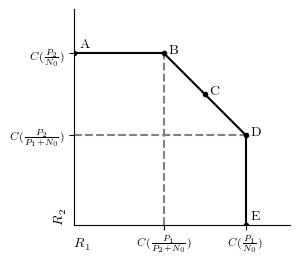

In [105]:
from utils import plot_pentagon
from utils import calculate_mac_rate_pairs
n=30
snr1=1.5
snr2=1.5

_, _, r1, c1, _, r2_mac, c2_mac = calculate_mac_rate_pairs(n, snr1, snr2) # u1 at full rate
_, _, r2, c2, _, r1_mac, c1_mac = calculate_mac_rate_pairs(n, snr2, snr1) # u2 at full rate
    
fig, ax = plt.subplots(1,1,figsize=set_size(width='conference', fraction=0.5))
fig, ax = plot_pentagon(n, snr1, snr2, fig, ax, do_r=False, do_tdma=False, points=['A', 'B', 'C', 'D', 'E'])
ax.axis('square')
ax.set_ylim([0,.8])
ax.set_xlim([0,0.8])
ax.set_xticks([c1_mac, c1], labels=['$C(\\frac{P_1}{P_2+N_0})$', '$C(\\frac{P_1}{N_0})$'])
ax.set_yticks([c2_mac, c2], labels=['$C(\\frac{P_2}{P_1+N_0})$', '$C(\\frac{P_2}{N_0})$'])
ax.set_xlabel('$R_1$',labelpad=-10,loc='left')
ax.set_ylabel('$R_2$', labelpad=-40, loc='bottom')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.savefig('./figures/pentagon.pdf', bbox_inches='tight', dpi=100)

when snr1 > snr2, it is better to decode user 2 first (point D)
when snr1 < snr2, it is better to decode user 1 first (point B)

--> decode weaker signal first (counter to description of SIC in sen, et al.

## distance to corner

To quantify how the two user sic algorithm works we define two measures

`distance_to_corner`, $D$ which is the Euclidian distance to the max sum capacity marked in the figures above (the highest achievable $R_2$ when user 1 is at single user capacity).

$D = | \bar{C} - \bar{GP} |_2$, where $\bar{C}, \bar{GP}$ are defined as vectors $(R_1, R_2)$

We also define the ratio between the achieved goodput and the max sum capacity

$\gamma = \frac{| \bar{GP} |}{| \bar{C} |}$

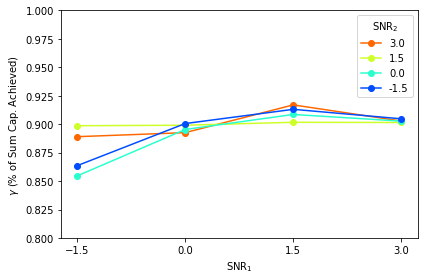

In [18]:
PUBLISH=False
if PUBLISH:
    fig, ax = plt.subplots(1,1,figsize=(set_size(width='conference', fraction=0.5)), tight_layout=True)
else:
    fig, ax = plt.subplots(1, 1,tight_layout=True)
    

color_idx = np.linspace(0.2,0.8, 4)

mac_rate = [calculate_rate(k=None, n=n, SNR=snr)[-2] for snr in [snr1, snr2_eff, snr3_eff]]


for i in reversed(range(4)):
    ax.plot(snr_set, gamma2[:,i], 'o-', color=mpl.cm.jet(color_idx[i]), label=snr_set[i])

ax.set_xticks(snr_set)
ax.set_xlabel('$\\mathrm{SNR}_1$')
ax.set_ylim([.8,1])
ax.set_ylabel('$\gamma$ (% of Sum Cap. Achieved)')
ax.legend(loc='upper right', title='$\\mathrm{SNR}_2$')

if PUBLISH:
        fig.savefig(f'./figures/2user_gamma_vs_snr')




### 3 user dist to sum cap

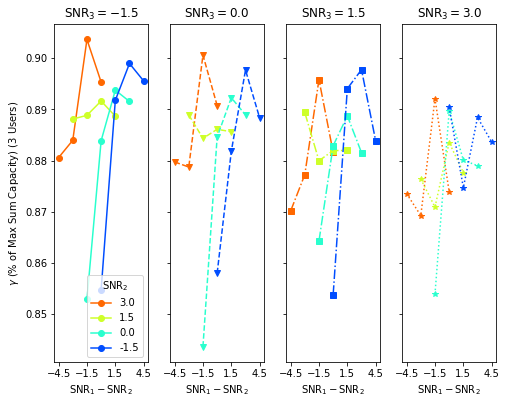

In [38]:
PUBLISH=True
if PUBLISH:
    fig, ax = plt.subplots(1,4,figsize=(set_size(width='conference', fraction=1)), tight_layout=True, sharey=True)
else:
    fig, ax = plt.subplots(1,4,tight_layout=True, sharey=True)


for i, snr2 in reversed(list(enumerate(snr_set))):
    for j, snr3 in enumerate(snr_set):
        ax[j].plot(delta2_snr[:,i], gamma3[:, i, j], linestyle[j], color=mpl.cm.jet(color_idx[i]), label=snr2)
        ax[j].set_xticks(np.unique(delta2_snr)[::2])
        ax[j].set_xlabel('$\mathrm{SNR}_1 - \mathrm{SNR}_2$')
        ax[j].set_title(f'$\mathrm{{SNR}}_3={{{snr3}}}$')
        if j==0:
            ax[j].legend(loc='lower right', title='$\mathrm{SNR}_2$')
            ax[j].set_ylabel('$\gamma$ (% of Max Sum Capacity) (3 Users)')
            
if PUBLISH:
        fig.savefig(f'./figures/3user_gamma_vs_delta')



### avg BER

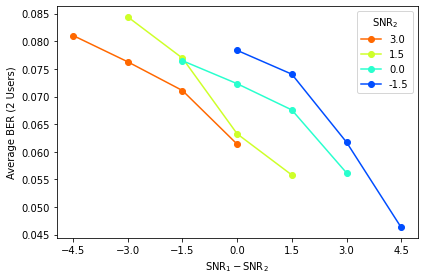

In [22]:
delta2_snr = np.reshape([s1-s2 for s1,s2 in product(snr_set, snr_set)],(4,4))
PUBLISH=False
if PUBLISH:
    fig, ax = plt.subplots(1,1,figsize=(set_size(width='conference', fraction=0.5)), tight_layout=True, sharey=True)
else:
    fig, ax = plt.subplots(1,1,tight_layout=True, sharey=True)

for j, snr2 in reversed(list(enumerate(snr_set))):
    ax.plot(delta2_snr[:,j], avg_ber2[:,j], 'o-',
             color=mpl.cm.jet(color_idx[j]), label=snr2)

ax.set_xticks(np.unique(delta2_snr))
ax.set_xlabel('$\mathrm{SNR}_1 - \mathrm{SNR}_2$')
ax.set_ylabel('Average BER (2 Users)')
ax.legend(title='$\mathrm{SNR}_2$')

if PUBLISH:
        fig.savefig(f'./figures/avg_ber2_vs_delta')




### 3 user

Text(0, 0.5, 'Average BER (3 Users)')

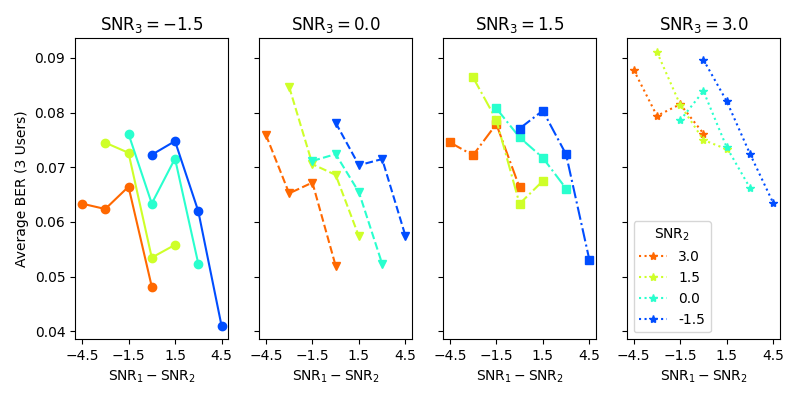

In [198]:
fig, ax = plt.subplots(1,4, figsize=(8,4),tight_layout=True, sharey=True)
for i, snr2 in reversed(list(enumerate(snr_set))):
    for j, snr3 in enumerate(snr_set):
        ax[j].plot(delta2_snr[:,i], avg_ber3[:, i, j], linestyles[j], color=mpl.cm.jet(color_idx[i]), label=snr2)
        ax[j].set_xticks(np.unique(delta2_snr)[::2])
        ax[j].set_xlabel('$\mathrm{SNR}_1 - \mathrm{SNR}_2$')
        ax[j].set_title(f'$\mathrm{{SNR}}_3={{{snr3}}}$')
ax[3].legend(title='$\mathrm{SNR}_2$')
ax[0].set_ylabel('Average BER (3 Users)')

In [190]:
# fig1 = plt.figure(figsize=(8,6),tight_layout=True)
# ax1 = fig1.add_subplot(projection='3d')
# fig2, ax2 = plt.subplots(1,1,figsize=(8,6),tight_layout=True)
# fig3, ax3 = plt.subplots(1,1,figsize=(8,6),tight_layout=True)


# markers=['o', 'v', 's', '*']
# for i, snr1 in enumerate(snr_set):
#     for j, snr2 in enumerate(snr_set):
#         for k, snr3 in enumerate(snr_set):
#             ax1.scatter(snr1-snr2, snr2-snr3, avg_ber3[i,j, k], s=size[i], marker=markers[j], 
#                    c=[snr3], cmap=cmap, norm=norm, 
#                    label=f'{snr1:.1f},{snr2:.1f}' if k==0 else None)
#             ax2.scatter(snr1-snr2,avg_ber3[i,j, k], s=size[i], marker=markers[j], 
#                    c=[snr3], cmap=cmap, norm=norm, 
#                    label=f'{snr1:.1f},{snr2:.1f}' if k==0 else None)
#             ax3.scatter(snr2-snr3, avg_ber3[i,j, k], s=size[i], marker=markers[j], 
#                    c=[snr3], cmap=cmap, norm=norm, 
#                    label=f'{snr1:.1f},{snr2:.1f}' if k==0 else None)

            
# ax1.set_xlabel('snr1-snr2')
# ax1.set_ylabel('snr2-snr3')

# ax2.set_xlabel('snr1-snr2')
# ax3.set_xlabel('snr2-snr3')

# ax1.legend(ncol=4,loc='upper left', title='$\mathrm{SNR}_1, \mathrm{SNR}_2$')
# cb = fig1.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
#             boundaries=np.linspace(-2.25,3.75,5),
#             ticks=snr_set
#                  )

# cb.ax.set_ylabel('$\mathrm{SNR}_3$', rotation=90)


Its really hard to tease anything out of the three user plts at all


In [190]:
# fig1 = plt.figure(figsize=(8,6),tight_layout=True)
# ax1 = fig1.add_subplot(projection='3d')
# fig2, ax2 = plt.subplots(1,1,figsize=(8,6),tight_layout=True)
# fig3, ax3 = plt.subplots(1,1,figsize=(8,6),tight_layout=True)


# markers=['o', 'v', 's', '*']
# for i, snr1 in enumerate(snr_set):
#     for j, snr2 in enumerate(snr_set):
#         for k, snr3 in enumerate(snr_set):
#             ax1.scatter(snr1-snr2, snr2-snr3, avg_ber3[i,j, k], s=size[i], marker=markers[j], 
#                    c=[snr3], cmap=cmap, norm=norm, 
#                    label=f'{snr1:.1f},{snr2:.1f}' if k==0 else None)
#             ax2.scatter(snr1-snr2,avg_ber3[i,j, k], s=size[i], marker=markers[j], 
#                    c=[snr3], cmap=cmap, norm=norm, 
#                    label=f'{snr1:.1f},{snr2:.1f}' if k==0 else None)
#             ax3.scatter(snr2-snr3, avg_ber3[i,j, k], s=size[i], marker=markers[j], 
#                    c=[snr3], cmap=cmap, norm=norm, 
#                    label=f'{snr1:.1f},{snr2:.1f}' if k==0 else None)

            
# ax1.set_xlabel('snr1-snr2')
# ax1.set_ylabel('snr2-snr3')

# ax2.set_xlabel('snr1-snr2')
# ax3.set_xlabel('snr2-snr3')

# ax1.legend(ncol=4,loc='upper left', title='$\mathrm{SNR}_1, \mathrm{SNR}_2$')
# cb = fig1.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
#             boundaries=np.linspace(-2.25,3.75,5),
#             ticks=snr_set
#                  )

# cb.ax.set_ylabel('$\mathrm{SNR}_3$', rotation=90)


### 2 user: distance to B vs. delta snr

With three users, looking at the BER vs. snr1, the relationship between snr1 and snr2 appears more complicated, but when we plot it vs the difference between snr1 and snr2, the traces separate.  The BER is no longer strictly decreasing in the snr1/2 delta, but there is a descreasing trend.  There is a clear increasing trend with snr3.  Ultimately, the lowest ber occurs when snr1 >> {snr2, snr3}

In [19]:
mac2_set = np.array(list(enumerate(mac_set)), dtype=object)[np.arange(0,64,4)]

Text(0, 0.5, 'Average BER (3 Users)')

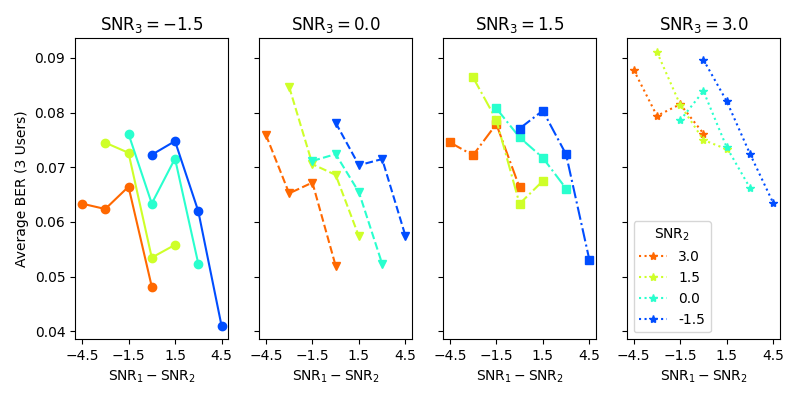

In [198]:
fig, ax = plt.subplots(1,4, figsize=(8,4),tight_layout=True, sharey=True)
for i, snr2 in reversed(list(enumerate(snr_set))):
    for j, snr3 in enumerate(snr_set):
        ax[j].plot(delta2_snr[:,i], avg_ber3[:, i, j], linestyles[j], color=mpl.cm.jet(color_idx[i]), label=snr2)
        ax[j].set_xticks(np.unique(delta2_snr)[::2])
        ax[j].set_xlabel('$\mathrm{SNR}_1 - \mathrm{SNR}_2$')
        ax[j].set_title(f'$\mathrm{{SNR}}_3={{{snr3}}}$')
ax[3].legend(title='$\mathrm{SNR}_2$')
ax[0].set_ylabel('Average BER (3 Users)')

To quantify how the two user sic algorithm works we define two measures

`distance_to_corner`, $D$ which is the Euclidian distance to the max sum capacity marked in the figures above (the highest achievable $R_2$ when user 1 is at single user capacity).

$D = | \bar{C} - \bar{GP} |_2$, where $\bar{C}, \bar{GP}$ are defined as vectors $(R_1, R_2)$

We also define the ratio between the achieved goodput and the max sum capacity

$\gamma = \frac{| \bar{GP} |}{| \bar{C} |}$

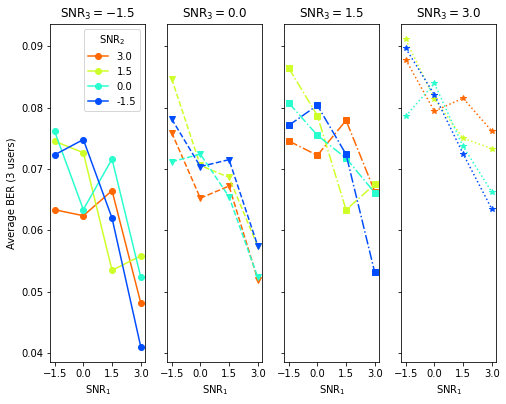

In [51]:
colors=['r','b','g','k']
linestyles=['o-', 'v--', 's-.', '*:']
avg_ber3 = np.mean(ber3, axis=3)

PUBLISH=True
if PUBLISH:
    fig, ax = plt.subplots(1,4,figsize=(set_size(width='conference', fraction=1.)), tight_layout=True, sharey=True)
else:
    fig, ax = plt.subplots(1,4,tight_layout=True, sharey=True)

for i, snr2 in reversed(list(enumerate(snr_set))):
    for j, snr3 in enumerate(snr_set):
        ax[j].plot(snr_set, avg_ber3[:, i, j], linestyles[j], color=mpl.cm.jet(color_idx[i]), label=snr2)
        ax[j].set_xticks(snr_set)
        ax[j].set_xlabel('$\mathrm{SNR}_1$')
        ax[j].set_title(f'$\mathrm{{SNR}}_3={{{snr3}}}$')
ax[0].legend(title='$\mathrm{SNR}_2$')
ax[0].set_ylabel('Average BER (3 users)')
# ax.legend(ncol=4, title='snr2, snr3')

if PUBLISH:
        fig.savefig(f'./figures/avg_ber2_vs_delta')



    

In [16]:
import matplotlib as mpl


size = 30*2.1**np.array([0, 1, 2, 3])

cmap = mpl.cm.jet
norm = mpl.colors.Normalize(vmin=-2, vmax=4)

gamma2 = np.zeros((len(snr_set), len(snr_set)))
gamma3 = np.zeros((len(snr_set), len(snr_set), len(snr_set)))

ber2 = np.zeros((len(snr_set), len(snr_set), 2))
ber3 = np.zeros((len(snr_set), len(snr_set), len(snr_set), 3))

for mac_test, (i1, i2, i3) in enumerate(mac_set):
        
    snr1=experiment_set[i1][2]
    snr2=experiment_set[i2][2]
    snr2_eff=experiment_set[i2][3]
    snr3=experiment_set[i3][2]
    snr3_eff=experiment_set[i3][3]


    mac2_cap = [calculate_rate(k=None, n=n, SNR=snr)[-1] for snr in [snr1, snr2_eff]]
    (c1, c2) = mac2_cap

    mac3_cap = [calculate_rate(k=None, n=n, SNR=snr)[-1] for snr in [snr1, snr2_eff, snr3_eff]]
    (c31, c32, c33) = mac3_cap


    mac2_gp = np.squeeze(sic2_data[mac_test,np.array(iterations_set)==iter_to_use,2,:])
    mac3_gp = np.squeeze(sic3_data[mac_test,np.array(iterations_set)==iter_to_use,2,:])

    ber2_tmp = np.squeeze(sic2_data[mac_test,np.array(iterations_set)==iter_to_use,1,:])
    ber3_tmp = np.squeeze(sic3_data[mac_test,np.array(iterations_set)==iter_to_use,1,:])
    
    ber2[snr_set==snr1, snr_set==snr2] = ber2_tmp
    ber3[snr_set==snr1, snr_set==snr2, snr_set==snr3] = ber3_tmp
    
    # calculate two user metrics
    D2 = np.linalg.norm(mac2_cap - mac2_gp)
    percent_of_corner = np.linalg.norm(mac2_gp)/np.linalg.norm(mac2_cap)

    gamma2[snr_set==snr1, snr_set==snr2] = percent_of_corner

    # calculate 3 user metric
    percent_of_corner = np.linalg.norm(mac3_gp)/np.linalg.norm(mac3_cap)
    gamma3[snr_set==snr1, snr_set==snr2, snr_set==snr3] = percent_of_corner


### 3 user

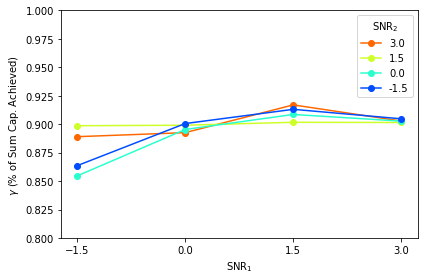

In [18]:
PUBLISH=False
if PUBLISH:
    fig, ax = plt.subplots(1,1,figsize=(set_size(width='conference', fraction=0.5)), tight_layout=True)
else:
    fig, ax = plt.subplots(1, 1,tight_layout=True)
    

color_idx = np.linspace(0.2,0.8, 4)

mac_rate = [calculate_rate(k=None, n=n, SNR=snr)[-2] for snr in [snr1, snr2_eff, snr3_eff]]


for i in reversed(range(4)):
    ax.plot(snr_set, gamma2[:,i], 'o-', color=mpl.cm.jet(color_idx[i]), label=snr_set[i])

ax.set_xticks(snr_set)
ax.set_xlabel('$\\mathrm{SNR}_1$')
ax.set_ylim([.8,1])
ax.set_ylabel('$\gamma$ (% of Sum Cap. Achieved)')
ax.legend(loc='upper right', title='$\\mathrm{SNR}_2$')

if PUBLISH:
        fig.savefig(f'./figures/2user_gamma_vs_snr')




average ber is decreasing in snr1-snr2, works best when snr1 >> snr2

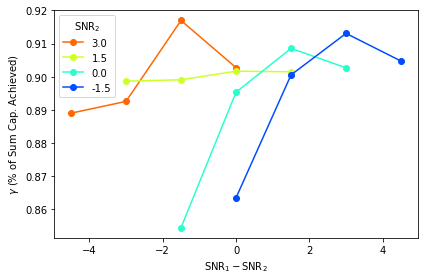

In [19]:
from itertools import product
delta2_snr = np.reshape([s1-s2 for s1,s2 in product(snr_set, snr_set)],(4,4))

PUBLISH=False
if PUBLISH:
    fig, ax = plt.subplots(1,1,figsize=(set_size(width='conference', fraction=0.5)), tight_layout=True)
else:
    fig, ax = plt.subplots(1, 1,tight_layout=True)
    


for j, snr2 in reversed(list(enumerate(snr_set))):
    ax.plot(delta2_snr[:,j], gamma2[:,j], 'o-',
             color=mpl.cm.jet(color_idx[j]), label=snr2)

ax.set_xlabel('$\mathrm{SNR}_1 - \mathrm{SNR}_2$')
ax.set_ylabel('$\gamma$ (% of Sum Cap. Achieved)')
ax.legend(title='$\mathrm{SNR}_2$')

if PUBLISH:
        fig.savefig(f'./figures/2user_gamma_vs_delta')




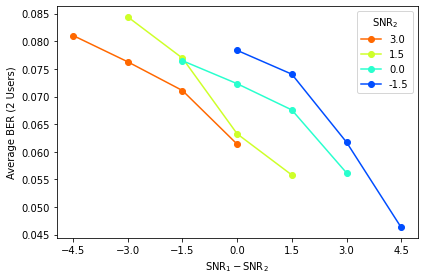

In [22]:
delta2_snr = np.reshape([s1-s2 for s1,s2 in product(snr_set, snr_set)],(4,4))
PUBLISH=False
if PUBLISH:
    fig, ax = plt.subplots(1,1,figsize=(set_size(width='conference', fraction=0.5)), tight_layout=True, sharey=True)
else:
    fig, ax = plt.subplots(1,1,tight_layout=True, sharey=True)

for j, snr2 in reversed(list(enumerate(snr_set))):
    ax.plot(delta2_snr[:,j], avg_ber2[:,j], 'o-',
             color=mpl.cm.jet(color_idx[j]), label=snr2)

ax.set_xticks(np.unique(delta2_snr))
ax.set_xlabel('$\mathrm{SNR}_1 - \mathrm{SNR}_2$')
ax.set_ylabel('Average BER (2 Users)')
ax.legend(title='$\mathrm{SNR}_2$')

if PUBLISH:
        fig.savefig(f'./figures/avg_ber2_vs_delta')




### 3 user dist to sum cap

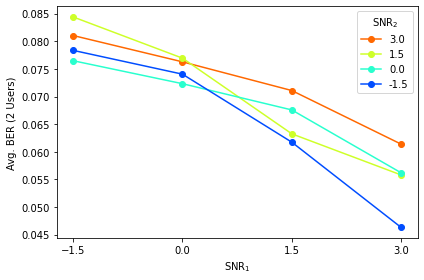

In [20]:
avg_ber2=np.mean(ber2, axis=2)
PUBLISH=False
if PUBLISH:
    fig, ax = plt.subplots(1,1,figsize=(set_size(width='conference', fraction=0.5)), tight_layout=True, sharey=True)
else:
    fig, ax = plt.subplots(1,1,tight_layout=True, sharey=True)

for i, snr2 in reversed(list(enumerate(snr_set))):
    ax.plot(snr_set, avg_ber2[:,i], 'o-', color=mpl.cm.jet(color_idx[i]), label=snr2)
ax.set_xticks(snr_set)
ax.set_xlabel('$\mathrm{SNR}_1$')
ax.set_ylabel('Avg. BER (2 Users)')
ax.legend(title='$\mathrm{SNR}_2$')

if PUBLISH:
        fig.savefig(f'./figures/avg_ber2_vs_snr')


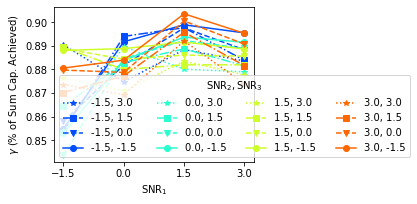

In [37]:
linestyle = ['o-', 'v--', 's-.', '*:']
color_idx = np.linspace(0.2,0.8, 4)
colors=['r', 'g', 'b', 'k']
mac_rate = [calculate_rate(k=None, n=n, SNR=snr)[-2] for snr in [snr1, snr2_eff, snr3_eff]]

PUBLISH=True
if PUBLISH:
    fig, ax = plt.subplots(1,1,figsize=(set_size(width='conference', fraction=0.5)))
else:
    fig, ax = plt.subplots(1, 1,tight_layout=True)


for i in range(4):
    for j in reversed(range(4)):
        ax.plot(snr_set, gamma3[:,i,j], linestyle[j], 
                color=mpl.cm.jet(color_idx[i]), 
#                 color=colors[i],
                label=f'{snr_set[i]:.1f}, {snr_set[j]:.1f}')
ax.set_xticks(snr_set)
ax.set_xlabel('$\\mathrm{SNR}_1$')
# ax.set_ylim([.8,1])
ax.set_ylabel('$\gamma$ (% of Sum Cap. Achieved)')
ax.legend(ncol=4, title='$\\mathrm{SNR}_2, \\mathrm{SNR}_3$')

if PUBLISH:
        fig.savefig(f'./figures/3user_gamma_vs_snr')




### avg BER

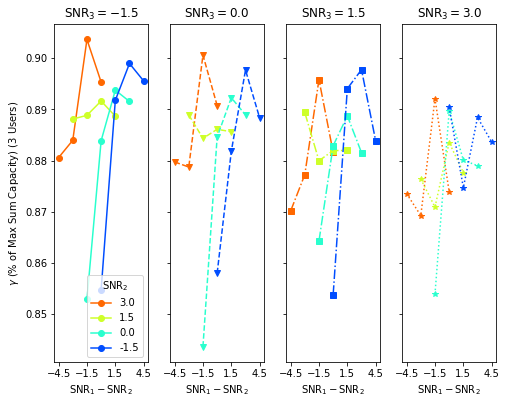

In [38]:
PUBLISH=True
if PUBLISH:
    fig, ax = plt.subplots(1,4,figsize=(set_size(width='conference', fraction=1)), tight_layout=True, sharey=True)
else:
    fig, ax = plt.subplots(1,4,tight_layout=True, sharey=True)


for i, snr2 in reversed(list(enumerate(snr_set))):
    for j, snr3 in enumerate(snr_set):
        ax[j].plot(delta2_snr[:,i], gamma3[:, i, j], linestyle[j], color=mpl.cm.jet(color_idx[i]), label=snr2)
        ax[j].set_xticks(np.unique(delta2_snr)[::2])
        ax[j].set_xlabel('$\mathrm{SNR}_1 - \mathrm{SNR}_2$')
        ax[j].set_title(f'$\mathrm{{SNR}}_3={{{snr3}}}$')
        if j==0:
            ax[j].legend(loc='lower right', title='$\mathrm{SNR}_2$')
            ax[j].set_ylabel('$\gamma$ (% of Max Sum Capacity) (3 Users)')
            
if PUBLISH:
        fig.savefig(f'./figures/3user_gamma_vs_delta')



same trend as two user, with slight decrease in snr3